# Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.


Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.


Идея решения задачи от заказчика: 
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.


На основе модели исследовать основные факторы ДТП.


Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?


Заказчик предлагает поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

## 1. Подключение к базе. Загрузка и первичное исследование таблиц SQL

### Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

### Подключение к базе

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'], 
    db_config['pwd'], 
    db_config['host'], 
    db_config['port'], 
    db_config['db']
    )

In [4]:
engine = create_engine(connection_string)

### Загрузка и первичное исследование таблиц

Таблица case_ids содержит уникальные case_id. Информации о db_year нет, но скорее всего, это год создания базы данных.

In [5]:
query = '''
    SELECT *
    FROM case_ids
    LIMIT 5
    '''

case_ids_df = pd.read_sql_query(query, con=engine)
case_ids_df

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Таблица vehicles содержит информацию о пострадавших машинах.

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

In [6]:
query = '''
    SELECT *
    FROM vehicles
    LIMIT 5
    '''

vehicles_df = pd.read_sql_query(query, con=engine)
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Таблица collisions содержит общую информацию о ДТП.

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [7]:
query = '''
    SELECT *
    FROM collisions
    LIMIT 5
    '''

collisions_df = pd.read_sql_query(query, con=engine)
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица parties содержит информацию об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

In [8]:
query = '''
    SELECT *
    FROM parties
    LIMIT 5
    '''

parties_df = pd.read_sql_query(query, con=engine)
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Все таблицы имеют общию ключ case_id. Могут отличаться названия столбцов, но в целом все данные на месте и соответствуют условию задачи.

## 2. Статистический анализ факторов ДТП

Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений.

In [9]:
query = '''
    SELECT EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
           COUNT(case_id) AS counter
    FROM collisions
    GROUP BY month
    ORDER BY counter DESC
    '''

collisions_count = pd.read_sql_query(query, con=engine)
collisions_count

,month,counter
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


<BarContainer object of 12 artists>

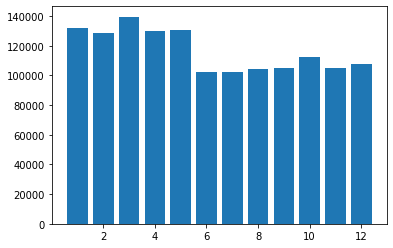

In [10]:
x = collisions_count['month']
y = collisions_count['counter']

plt.bar(x, y)

По данным таблицы, большая часть зарегистрированных происшествий имеет место в первые пять месяцев года. Это можно было бы объяснить погодными факторами, но как можно заметить из графика, есть четкое разделение данных: 1-5 месяцы в среднем по 13к значений, в 6-12 месяцы - по 10к значений. Возможно, это говорит о недостатке данных в таблице.

### Аналитические задачи для рабочей группы:


- проанализировать, влияет возраст автомобиля на серьезность происшествия
- как распределяется количество аварий по типу КП в разных погодных условиях? влияет ли тип КП на управляемость автомобилем в сложных погодных условиях?
- проанализировать сумму страховых выплат по месяцам, оценить среднюю страховку. влияет ли сезонность на сумму?
- влияет ли тип дорожного покрытия и степень естественного освещения на степень вины водителя в ДТП?
- оценить в какие часы суток чаще происходят аварии по вине пьяных водителей
- зависит ли количество аварий от типа кузова автомобиля? столько участников вовлечено в такие ДТП?

Пропишем порядок решения для двух задач из списка.

Задача 1. Проанализируем влияние возраста автомобиля на серьезность происшествия.

In [11]:
query = '''
    WITH rank AS
        (SELECT vehicle_age,
                collision_damage,
                COUNT(c.case_id) AS count,
                SUM(COUNT(c.case_id)) OVER (PARTITION BY vehicle_age) AS sum,
                ROW_NUMBER() OVER (PARTITION BY vehicle_age ORDER BY vehicle_age, COUNT(c.case_id) DESC) AS rn
         FROM collisions AS c
         JOIN vehicles AS v ON c.case_id = v.case_id
         WHERE vehicle_age != 161
            AND vehicle_age IS NOT NULL
         GROUP BY vehicle_age, collision_damage)
    
    SELECT vehicle_age,
           collision_damage,
           (count / sum) * 100 AS share
    FROM rank
    WHERE collision_damage = 'fatal'
    '''

df_1 = pd.read_sql_query(query, con=engine)
df_1

,vehicle_age,collision_damage,share
0,0,fatal,0.568775
1,1,fatal,0.583436
2,2,fatal,0.764104
3,3,fatal,1.387847
4,4,fatal,1.491169
5,5,fatal,1.430000
6,6,fatal,1.520827
7,7,fatal,1.651598
8,8,fatal,1.889192
9,9,fatal,2.046176


Выбирая разные значения в операторе WHERE в итоговой части запроса, мы можем вывести долю повреждений относительно общего числа аварий по каждому возрасту автомобиля. Например, посмотреть долю самых популярный повреждений для rn = 1. В нашем запросе выводится доля повреждений, когда автомобиль не подлежит восстановлению.


Как видно по таблице, и график это подтверждает, действительно, чем старше автомобиль, тем чаще последствия аварии оказываются для него фатальными.

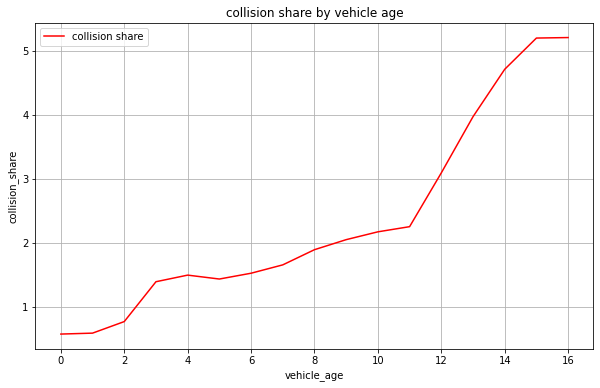

In [12]:
plt.figure(figsize=[10,6])
sns.lineplot(data=df_1, x='vehicle_age', y='share', label='collision share', color='red')

plt.legend()
plt.title('collision share by vehicle age')
plt.xlabel('vehicle_age')
plt.ylabel('collision_share')
plt.grid()
plt.show()

Задача 2. Посмотрим, влияет ли тип КП на управляемость автомобилем в разных погодных условиях.

In [13]:
query = '''
    SELECT c.weather_1,
           v.vehicle_transmission, 
           COUNT(c.case_id)
    FROM collisions AS c
    JOIN vehicles AS v ON c.case_id = v.case_id
    WHERE c.weather_1 IS NOT NULL
        AND v.vehicle_transmission IS NOT NULL
    GROUP BY c.weather_1, v.vehicle_transmission
    '''

df_1 = pd.read_sql_query(query, con=engine)
df_1

,weather_1,vehicle_transmission,count
0,clear,auto,406497
1,clear,manual,402109
2,cloudy,auto,71371
3,cloudy,manual,69494
4,fog,auto,1567
5,fog,manual,2162
6,other,auto,300
7,other,manual,349
8,raining,auto,19160
9,raining,manual,17968


Полученные данные показывают, что тип КП не оказывает влияния на частоту аварий при любом типе погоды. Одинаково попадают в аварии автомобили как с механикой, так и с автоматом. Можно также заметить большое число аварий в ясную погоду.

<AxesSubplot:xlabel='weather_1', ylabel='count'>

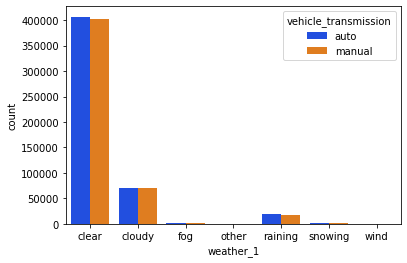

In [14]:
sns.barplot(
    x='weather_1', 
    y='count', 
    data=df_1, 
    palette='bright',
    hue='vehicle_transmission')

## 3. Создание модели для оценки водительского риска

### Подготовка набора данных

На основе первичного предложения заказчика подготовим следующий набор данных:
- выберем тип виновника 'car'
- возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников кроме типа 'scratch'
- для моделирования возьмем данные только за 2012 г.

### Первичный отбор факторов, необходимых для обучения модели

По заданию, мы должны создать модель, которая будет оценивать риск ДТП по выбранному маршруту. Отберем признаки, которые помогут решить эту задачу.

Таблица collisions:
- case_id - нам понадобится уникальный номер происшествия для сбора данных
- collision_date - извлечем месяц происшествия для оценки сезонности
- collision_time - извлечем час дня для оценки влияния времени суток на ДТП
- weather_1 - погодные условия, очевидно, влияют на безопасность на дорогах
- road_surface - состояние дороги
- lighting - дополнит пункт времени суток, так как в разные сезоны и в разных широтах, условия освещения могут быть разные
- county_location - название населенного пункта поможет оценить сложность трафика, в крупных городах, очевидно, ездить сложнее
- location_type - тип дороги напрямую может влиять на вероятность ДТП
- road_condition_1 - состояние дороги
- control_condotion - непонятный признак, возьмем на всякий

Таблица parties:
- at_fault - целевой признак
- party_drug_physical - физическое состояние участников влияет на риски на дорогах
- party_sobriety - аналогично с трезвостью
- cellphone_in_use - пользование телефоном во время движения также может увеличивать риски ДТП

Таблица vehicles:
- vehicles_type - тип автомобиля может иметь значение
- vehicle_transmission - аналогично с типом КП
- vehicle_age - возраст автомобиля, соответственно, тоже важен

Не берем признаки:
- intersection - уже есть в location_type
- collision_damage - относится уже к последствиям, а не к причинам
- county_city_location - не имеет значения
- direction - непонятно
- distance - похоже на location_type
- party_count - для нас имеет значение вероятность ДТП, а не число его участников
- primary_collision_factor
- pcf_violation_category
- type_of_collision
- motor_vehicle_involved_with


- party_type - уже отсортировали
- insurance_premium - не имеет отношения

In [15]:
query = '''
    SELECT DISTINCT(p.case_id) AS id,
           EXTRACT(MONTH FROM CAST(collision_date AS date)) AS month,
           EXTRACT(HOUR FROM collision_time) AS hour,
           weather_1 AS weather,
           road_surface,
           lighting,
           county_location,
           location_type,
           road_condition_1 AS road_condition,
           control_device,
           at_fault,
           party_drug_physical,
           party_sobriety,
           cellphone_in_use,
           vehicle_type,
           vehicle_transmission,
           vehicle_age
    FROM parties AS p
    LEFT JOIN collisions AS c ON p.case_id = c.case_id
    LEFT JOIN vehicles AS v ON (p.case_id = v.case_id AND p.party_number = v.party_number)
    WHERE collision_damage != 'scratch'
        AND EXTRACT(YEAR FROM CAST(collision_date AS date)) = '2012'
            AND party_type = 'car'
    '''

data = pd.read_sql_query(query, con=engine)
data.head()

,id,month,hour,weather,road_surface,lighting,county_location,location_type,road_condition,control_device,at_fault,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,5064690,1.0,10.0,clear,dry,daylight,alameda,ramp,normal,none,1,None,had not been drinking,0.0,None,None,NaN
1,5125160,3.0,7.0,cloudy,dry,daylight,san diego,None,other,none,0,None,had not been drinking,0.0,sedan,auto,2.0
2,5125160,3.0,7.0,cloudy,dry,daylight,san diego,None,other,none,1,None,had not been drinking,0.0,None,None,NaN
3,5125192,3.0,14.0,cloudy,dry,daylight,santa clara,None,normal,functioning,1,None,had not been drinking,0.0,None,None,NaN
4,5173738,4.0,12.0,clear,dry,daylight,sacramento,None,normal,none,0,None,had not been drinking,0.0,sedan,auto,5.0


### Cтатистическое исследование отобранных факторов

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188836 entries, 0 to 188835
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    188836 non-null  object 
 1   month                 188836 non-null  float64
 2   hour                  187473 non-null  float64
 3   weather               188223 non-null  object 
 4   road_surface          187625 non-null  object 
 5   lighting              188142 non-null  object 
 6   county_location       188836 non-null  object 
 7   location_type         82315 non-null   object 
 8   road_condition        187759 non-null  object 
 9   control_device        187917 non-null  object 
 10  at_fault              188836 non-null  int64  
 11  party_drug_physical   25004 non-null   object 
 12  party_sobriety        185299 non-null  object 
 13  cellphone_in_use      164070 non-null  float64
 14  vehicle_type          56124 non-null   object 
 15  

Проверим полученный датасет на пропуски и дубликаты.

In [17]:
data.isna().sum()

id                           0
month                        0
hour                      1363
weather                    613
road_surface              1211
lighting                   694
county_location              0
location_type           106521
road_condition            1077
control_device             919
at_fault                     0
party_drug_physical     163832
party_sobriety            3537
cellphone_in_use         24766
vehicle_type            132712
vehicle_transmission    133569
vehicle_age             134400
dtype: int64

In [18]:
data.duplicated().sum()

0

### month

Данные по месяцам распределены неравномерно, поэтому удалим этот столбец из анализа.

<AxesSubplot:>

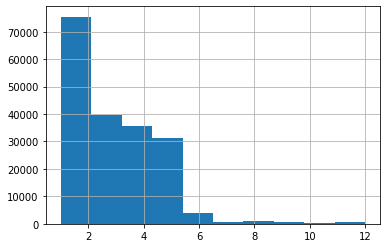

In [19]:
data['month'].hist()

In [20]:
data = data.drop(columns=['month'], axis=1)

### hour

Удалим пропуски. В остальном без изменений. Как видно из гистограммы, утром, днем, вечером совершается больше поездок, чем ночью, что выглядит репрезентативно.

In [21]:
data['hour'].isna().sum()

1363

<AxesSubplot:>

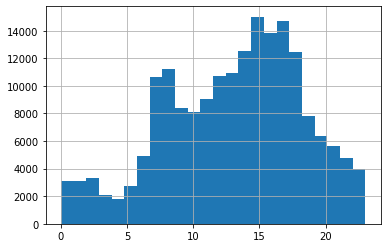

In [22]:
data['hour'].hist(bins=24)

In [23]:
data = data.dropna(subset=['hour'])

### weather

Удалим пропуски, заменим небольшие значения на other

In [24]:
data['weather'].isna().sum()

592

In [25]:
data['weather'].value_counts()

clear      149791
cloudy      28148
raining      7782
fog           557
snowing       420
other         138
wind           45
Name: weather, dtype: int64

In [26]:
data['weather'] = data['weather'].str.replace('fog', 'other')
data['weather'] = data['weather'].str.replace('snowing', 'other')
data['weather'] = data['weather'].str.replace('wind', 'other')

In [27]:
data = data.dropna(subset=['weather'])

### road_surface

In [28]:
data['road_surface'].isna().sum()

909

In [29]:
data['road_surface'].value_counts()

dry         166872
wet          18070
snowy          890
slippery       140
Name: road_surface, dtype: int64

In [30]:
data = data.dropna(subset=['road_surface'])

In [31]:
data['road_surface'] = data['road_surface'].str.replace('snowy', 'other')
data['road_surface'] = data['road_surface'].str.replace('slippery', 'other')

### lighting

Удалим пропуски, включим редкое значение dark with street lights not functioning в dark with no street lights что по сути то же самое

In [32]:
data['lighting'].isna().sum()

378

In [33]:
data['lighting'].value_counts()

daylight                                   128821
dark with street lights                     36316
dark with no street lights                  13664
dusk or dawn                                 6377
dark with street lights not functioning       416
Name: lighting, dtype: int64

In [34]:
data['lighting'] = data['lighting'].str.replace('dark with street lights not functioning', 'dark with no street lights')

In [35]:
data = data.dropna(subset=['lighting'])

### county_location

Оставим только 30 самых популярных локаций, остальное заменим на other

In [36]:
data['county_location'].value_counts()

los angeles        60393
orange             17270
san bernardino     10883
riverside          10170
san diego           9569
alameda             7705
sacramento          7040
santa clara         6463
ventura             4737
kern                4082
contra costa        4031
san mateo           3465
san joaquin         2835
fresno              2830
tulare              2764
santa barbara       2606
stanislaus          2408
sonoma              2269
monterey            2108
placer              1901
solano              1638
san francisco       1635
san luis obispo     1486
santa cruz          1420
marin               1405
merced              1235
yolo                1040
humboldt             912
butte                828
madera               763
shasta               744
el dorado            742
napa                 626
kings                591
nevada               541
mendocino            533
imperial             500
tehama               386
sutter               379
yuba                 290


In [37]:
top_30 = data['county_location'].value_counts(normalize=True).sort_values(ascending=False)[:30].index
data['county_location'] = data['county_location'].where((data['county_location'].isin(top_30)), 'other')

### location_type

Пропуски заменим на other

In [38]:
data['location_type'].isna().sum()

104002

In [39]:
data['location_type'].value_counts()

highway         66826
ramp            10994
intersection     3772
Name: location_type, dtype: int64

In [40]:
data['location_type'] = data['location_type'].fillna('other')

### road_condition

Пропуски и редкие значение заменим на other

In [41]:
data['road_condition'].isna().sum()

752

In [42]:
data['road_condition'].value_counts()

normal            179303
construction        3124
other                731
obstruction          681
holes                401
loose material       299
reduced width        201
flooded              102
Name: road_condition, dtype: int64

In [43]:
data = data.dropna(subset=['road_condition'])

In [44]:
data['road_condition'] = data['road_condition'].str.replace('obstruction', 'other')
data['road_condition'] = data['road_condition'].str.replace('holes', 'other')
data['road_condition'] = data['road_condition'].str.replace('loose material', 'other')
data['road_condition'] = data['road_condition'].str.replace('reduced width', 'other')
data['road_condition'] = data['road_condition'].str.replace('flooded', 'other')

### control_device

Удалим пропуски и пару редких значений.

In [45]:
data['control_device'].isna().sum()

720

In [46]:
data['control_device'].value_counts()

none               124375
functioning         59242
not functioning       409
obscured               96
Name: control_device, dtype: int64

In [47]:
data = data.dropna(subset=['control_device'])

In [48]:
data = data.query('control_device != "not functioning"')
data = data.query('control_device != "obscured"')

### at_fault

In [49]:
data['at_fault'].value_counts()

1    99936
0    83681
Name: at_fault, dtype: int64

### party_drug_physical

Согласно документации, категория G (не известно) похожа на not applicable. Можно сделать соответствующую замену пропусков и G

In [50]:
data['party_drug_physical'].isna().sum()

160285

In [51]:
data['party_drug_physical'].value_counts()

G                        18936
not applicable            1515
under drug influence      1467
sleepy/fatigued           1083
impairment - physical      331
Name: party_drug_physical, dtype: int64

In [52]:
data['party_drug_physical'] = data['party_drug_physical'].fillna('not applicable')
data['party_drug_physical'] = data['party_drug_physical'].str.replace('G', 'not applicable')

### party_sobriety

Удалим пропуски, уберем детали в had been drinking

In [53]:
data['party_sobriety'].isna().sum()

3192

In [54]:
data['party_sobriety'].value_counts()

had not been drinking                     147085
impairment unknown                         18936
had been drinking, under influence         10008
had been drinking, impairment unknown       1568
not applicable                              1515
had been drinking, not under influence      1313
Name: party_sobriety, dtype: int64

In [55]:
data = data.dropna(subset=['party_sobriety'])

In [56]:
data['party_sobriety'] = data['party_sobriety'].str.replace('had been drinking, under influence', 'had been drinking')
data['party_sobriety'] = data['party_sobriety'].str.replace('had been drinking, impairment unknown', 'had been drinking')
data['party_sobriety'] = data['party_sobriety'].str.replace('had been drinking, not under influence', 'had been drinking')

In [57]:
data = data.query('party_sobriety != "not applicable"')

### cellphone_in_use

Удалим пропуски

In [58]:
data['cellphone_in_use'].isna().sum()

21210

In [59]:
data['cellphone_in_use'].value_counts()

0.0    153939
1.0      3761
Name: cellphone_in_use, dtype: int64

In [60]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(0)

In [61]:
data['cellphone_in_use'].value_counts()

0.0    175149
1.0      3761
Name: cellphone_in_use, dtype: int64

### vehicle_type

Заменим пропуски на other

In [62]:
data['vehicle_type'].isna().sum()

124977

In [63]:
data['vehicle_type'].value_counts()

sedan    35864
coupe    18067
other        2
Name: vehicle_type, dtype: int64

In [64]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

### vehicle_transmission

Машины с АКПП и МКПП представлены примерно одинаково. Пропусков в данных очень много. Ранее мы выяснили, что на управляемость в разных погодных условиях это не сильно влияет. Можем удалить этот столбец целиком.

In [65]:
data['vehicle_transmission'].isna().sum()

125777

In [66]:
data['vehicle_transmission'].value_counts()

manual    28115
auto      25018
Name: vehicle_transmission, dtype: int64

In [67]:
data = data.drop(columns=['vehicle_transmission'], axis=1)

### vehicle_age

Оставим только автомобили 11 лет и меньше. Пропуски заменим на медиану.

In [68]:
data['vehicle_age'].isna().sum()

126572

In [69]:
data['vehicle_age'].value_counts()

3.0      10531
4.0       6868
2.0       5843
5.0       5333
6.0       3785
7.0       3691
8.0       3359
0.0       2984
9.0       2654
1.0       2427
10.0      1854
11.0      1325
12.0       842
13.0       522
14.0       273
15.0        36
16.0         6
17.0         2
161.0        2
19.0         1
Name: vehicle_age, dtype: int64

In [70]:
data = data.query('vehicle_age != 161')

In [71]:
data['vehicle_age'].describe()

count    52336.000000
mean         4.846836
std          3.092987
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         19.000000
Name: vehicle_age, dtype: float64

<AxesSubplot:>

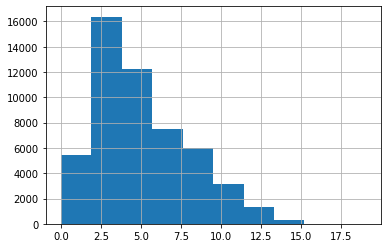

In [72]:
data['vehicle_age'].hist()

In [73]:
data['vehicle_age'] = data['vehicle_age'].fillna(data['vehicle_age'].median())

In [74]:
data['vehicle_age'].value_counts()

4.0     133440
3.0      10531
2.0       5843
5.0       5333
6.0       3785
7.0       3691
8.0       3359
0.0       2984
9.0       2654
1.0       2427
10.0      1854
11.0      1325
12.0       842
13.0       522
14.0       273
15.0        36
16.0         6
17.0         2
19.0         1
Name: vehicle_age, dtype: int64

In [75]:
data = data.query('vehicle_age < 12')

По итогам всех преобразований было удалено менее 10% данных.

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177226 entries, 0 to 188835
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   177226 non-null  object 
 1   hour                 177226 non-null  float64
 2   weather              177226 non-null  object 
 3   road_surface         177226 non-null  object 
 4   lighting             177226 non-null  object 
 5   county_location      177226 non-null  object 
 6   location_type        177226 non-null  object 
 7   road_condition       177226 non-null  object 
 8   control_device       177226 non-null  object 
 9   at_fault             177226 non-null  int64  
 10  party_drug_physical  177226 non-null  object 
 11  party_sobriety       177226 non-null  object 
 12  cellphone_in_use     177226 non-null  float64
 13  vehicle_type         177226 non-null  object 
 14  vehicle_age          177226 non-null  float64
dtypes: float64(3), in

Удалим 'id' (больше не нужен) и сбросим индекс.

In [77]:
data = data.drop(columns=['id'], axis=1)

In [78]:
data.reset_index(drop=True, inplace=True)

In [79]:
data.head()

,hour,weather,road_surface,lighting,county_location,location_type,road_condition,control_device,at_fault,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age
0,10.0,clear,dry,daylight,alameda,ramp,normal,none,1,not applicable,had not been drinking,0.0,other,4.0
1,7.0,cloudy,dry,daylight,san diego,other,other,none,0,not applicable,had not been drinking,0.0,sedan,2.0
2,7.0,cloudy,dry,daylight,san diego,other,other,none,1,not applicable,had not been drinking,0.0,other,4.0
3,14.0,cloudy,dry,daylight,santa clara,other,normal,functioning,1,not applicable,had not been drinking,0.0,other,4.0
4,12.0,clear,dry,daylight,sacramento,other,normal,none,0,not applicable,had not been drinking,0.0,sedan,5.0


### Подготовка выборок

Выделим признаки и целевой признак.

In [80]:
features = data.drop(columns=['at_fault'], axis=1)
target = data['at_fault']

По сути все признаки кроме 'vehicle_age' можно обозначить как категориальные (включая 'month', 'hour', так как они обозначают сезонность и время суток).

In [81]:
features.columns

Index(['hour', 'weather', 'road_surface', 'lighting', 'county_location',
       'location_type', 'road_condition', 'control_device',
       'party_drug_physical', 'party_sobriety', 'cellphone_in_use',
       'vehicle_type', 'vehicle_age'],
      dtype='object')

Выделим признаки, выраженные через текст.

In [82]:
text = ['weather', 'road_surface', 'lighting', 'county_location',
       'location_type', 'road_condition', 'control_device',
       'party_drug_physical', 'party_sobriety', 'vehicle_type']

Разделим датасет на обучающую, валидационную и тестовую выборки.

In [83]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345)

In [84]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test,
                                                                            test_size=0.5, 
                                                                            random_state=12345)

In [85]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(106335, 13)
(106335,)
(35446, 13)
(35446,)
(35445, 13)
(35445,)


Преобразуем категориальные признаки в числа.

In [86]:
encoder = OneHotEncoder()

In [87]:
features_train = encoder.fit_transform(features_train)
features_valid = encoder.transform(features_valid)
features_test = encoder.transform(features_test)

## 4. Поиск лучшей модели

Рассмотрим несколько обучающих моделей для поиска оптимального решения.

### Метрика

В качестве целевой метрики выберем precision, так как нам важно не просто угаданное количество правильных ответов. Нам важно оценить, сколько водителей, определенных, как виновные в аварии, действительно оказалась виновными.

### Баланс классов

Для начала проверим баланс классов. Соотношение классов близко к 1:1, их можно считать сбалансированными.

<AxesSubplot:>

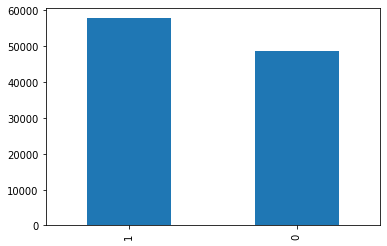

In [92]:
class_frequency = target_train.value_counts()
class_frequency.plot(kind='bar')

In [93]:
class_frequency[0] / class_frequency[1]

0.8416494916780686

### Функция

In [98]:
def predict_model(model):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = precision_score(target_valid, predictions_valid)
    
    return result

### Логистическая регрессия

In [99]:
%%time

lr_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
lr_result = predict_model(lr_model)

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.81 s


In [100]:
lr_result

0.6770293609671848

### Дерево решений

In [101]:
%%time

dtc_model = None
dtc_result = 0

for depth in range(1, 10):
    for leaf in range(1, 5):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        result = predict_model(model)
    
        if result > dtc_result:
            dtc_model = model
            dtc_result = result

CPU times: user 10.4 s, sys: 12.4 ms, total: 10.4 s
Wall time: 10.4 s


In [102]:
dtc_result, dtc_model

(0.8641857506361323, DecisionTreeClassifier(max_depth=1, random_state=12345))

### Случайный лес

In [103]:
%%time

rfc_model = None
rfc_result = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        result = predict_model(model)
    
        if result > rfc_result:
            rfc_model = model
            rfc_result = result

CPU times: user 23.4 s, sys: 29.6 ms, total: 23.5 s
Wall time: 23.5 s


In [104]:
rfc_result, rfc_model

(0.7478067857520346,
 RandomForestClassifier(max_depth=3, n_estimators=1, random_state=12345))

### LightGBM

In [105]:
%%time

lgbm_model = None
lgbm_result = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model = LGBMClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        result = predict_model(model)
        
        if result > lgbm_result:
            lgbm_result = result
            lgbm_model = model

CPU times: user 3min 9s, sys: 1.02 s, total: 3min 10s
Wall time: 3min 12s


In [106]:
lgbm_result, lgbm_model

(0.8641857506361323,
 LGBMClassifier(max_depth=1, n_estimators=9, random_state=12345))

### CatBoost

In [107]:
%%time

cat_model = None
cat_result = 0

for est in range(1, 15):
    for depth in range(1, 10):
        model = CatBoostClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        result = predict_model(model)
        
        if result > cat_result:
            cat_result = result
            cat_model = model

Learning rate set to 0.5
0:	learn: 0.6492770	total: 69.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6478069	total: 19.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6464988	total: 23.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6458803	total: 18.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6444140	total: 20.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6438553	total: 21.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6422753	total: 24.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6422885	total: 30.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6418224	total: 42.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6492770	total: 13.9ms	remaining: 13.9ms
1:	learn: 0.6404016	total: 28.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6478069	total: 18.6ms	remaining: 18.6ms
1:	learn: 0.6374261	total: 34.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6464988	total: 16.8ms	remaining: 16.8ms
1:	le

In [108]:
cat_result, cat_model

(0.8658937803540655, <catboost.core.CatBoostClassifier at 0x7fcd03f1b520>)

### Выбор лучшей модели

In [109]:
result = pd.DataFrame ([
    [lr_result],
    [dtc_result],
    [rfc_result],
    [lgbm_result],
    [cat_result]], 
    columns=['precision'],
    index=['LogisticRegression', 'DecisionTree','RandomForest', 'LightGBM', 'CatBoost'])

result.sort_values(by='precision', ascending=False)

,precision
CatBoost,0.865894
DecisionTree,0.864186
LightGBM,0.864186
RandomForest,0.747807
LogisticRegression,0.677029


Лучший результат показала модель дерева решений, продолжим работу с ней.

## 6. Проверка лучшей модели в работе

### Матрица ошибок

Проверим модель на тестовой выборке и расчитаем остальные метрики.

In [110]:
dtc_predictions = dtc_model.predict(features_test)
dtc_precision = precision_score(target_test, dtc_predictions)
dtc_recall = recall_score(target_test, dtc_predictions)
dtc_f1 = f1_score(target_test, dtc_predictions)

dtc_precision, dtc_recall, dtc_f1

(0.8648859731333958, 0.289002557544757, 0.4332381362231524)

Судя по матрице ошибок, модель часто признает виновными водителей, которые на самом деле не были выновны. Но, возможно, для наших целей такая "осторожность" модели даже хорошо.

In [111]:
confusion_matrix(target_test, dtc_predictions)

array([[15421,   865],
       [13622,  5537]])

In [112]:
probabilities_test = dtc_model.predict_proba(features_test)

Изобразим на графике, как будут выглядеть изменения метрик при изменении порога классификации.

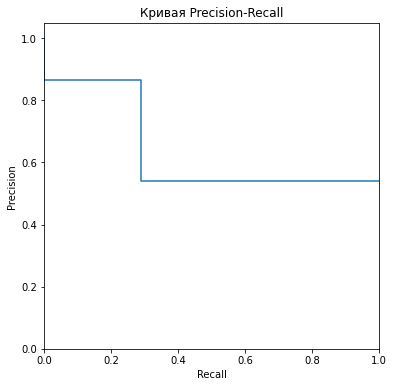

In [113]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

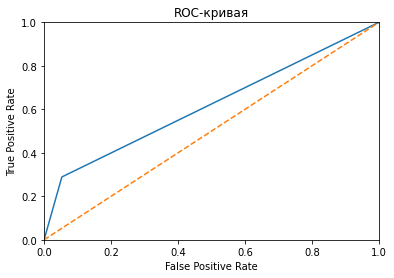

In [114]:
precision, recall, thresholds = roc_curve(target_test, probabilities_test[:, 1])

plt.figure()
plt.plot(precision, recall)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Анализ кривой ошибок показывает, что модель работает неидеально, но все-таки лучше, чем случайным образом.

In [115]:
auc_roc = roc_auc_score(target_test, probabilities_test[:, 1])
auc_roc

0.6179447271329336

### Анализ важности основных факторов

Как видно из графика ниже, в целом признаки не очень сильно коррелируют друг с другом, включая целевой признак. Возможно, было отобрано слишком большое количество признаков, и если уменьшить их количество, то связи улучшатся.


Но можно отметить сильную корреляцию между погодными условиями и качеством дорожного покрытия.

<AxesSubplot:>

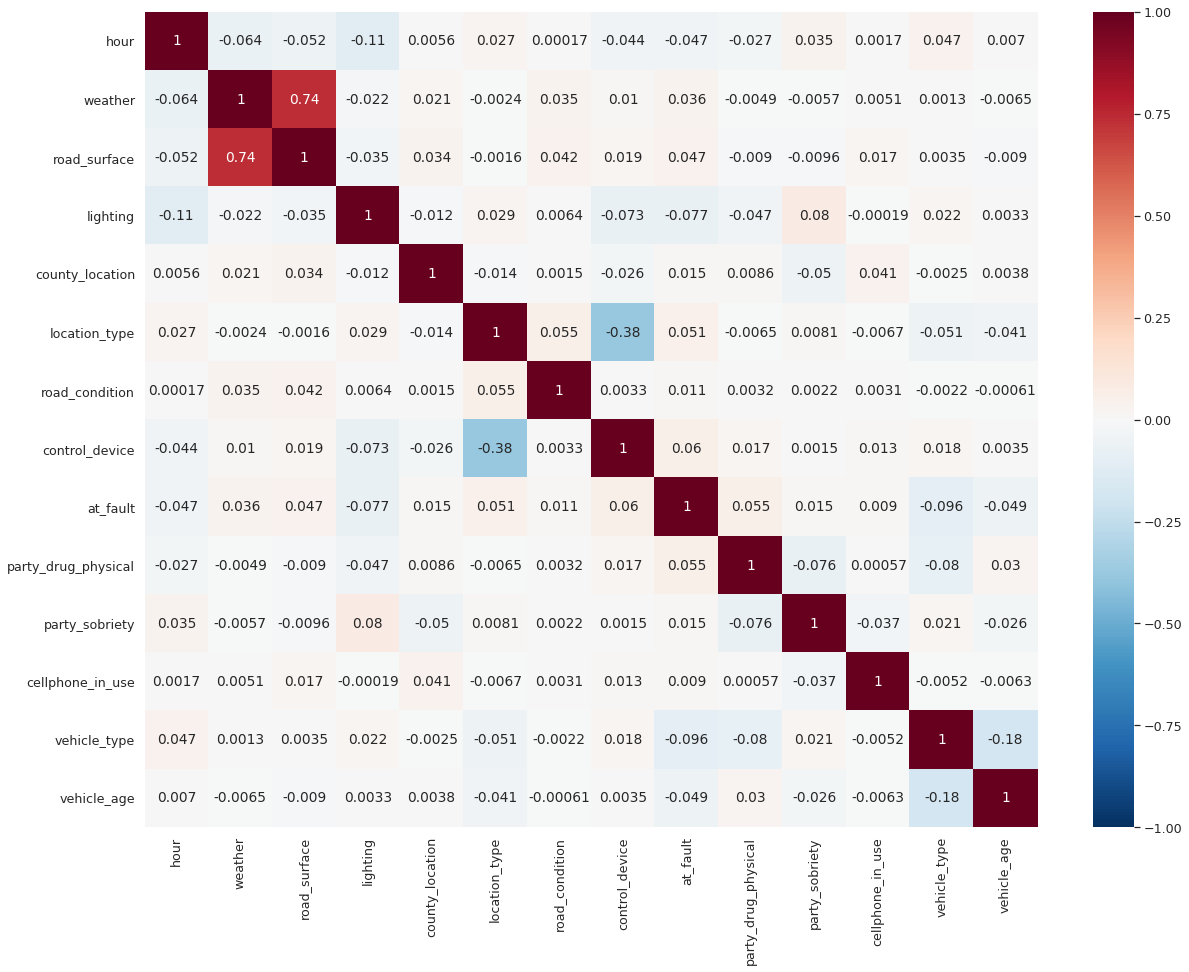

In [116]:
data_encoded = pd.DataFrame(OrdinalEncoder().fit_transform(data), columns=data.columns)

sns.set(font_scale=1.15)
plt.figure(figsize=(20,15))
sns.heatmap(
    data_encoded.corr(),        
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

In [117]:
importances = dtc_model.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False)

80    1.0
0     0.0
63    0.0
72    0.0
71    0.0
     ... 
30    0.0
29    0.0
28    0.0
27    0.0
98    0.0
Length: 99, dtype: float64

### Решение для одного из выявленных факторов

Как следует из тепловой карты, один из признаков, с которым у целевого признака есть заметная коореляция - это тип дороги. На шоссе вина за аварии распределена примерно поровну. На участках, определенных как другие (т.е. не шоссе, перекрестки, рампы) ДТП чаще случаются по вине водителей.


Решение этой проблемы может быть в следующем:
- установка видеорегистраторов для защиты от внешних угроз
- для водителя: системы контроля вождения, например, датчики, которые будут оценивать усилие при нажатиях на тормоз или угол поворота руля. Это поможет понять, насколько аккуратно управляет автомобилем водитель

(array([0, 1, 2, 3]),
 [Text(0, 0, 'ramp'),
  Text(1, 0, 'other'),
  Text(2, 0, 'highway'),
  Text(3, 0, 'intersection')])

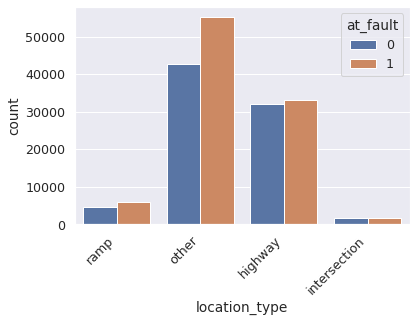

In [118]:
sns.countplot(data=data, x="location_type", hue="at_fault")
plt.xticks(rotation=45, 
           ha='right')

## Вывод

Перед нами стояла задача создания системы, которая могла бы оценить риск ДТП по выбранному маршруту движения. Наша модель на основе исторических данных должна предсказывать вероятность ДТП. Также на основе модели было необходимо исследовать основные факторы ДТП. 

В нашем распоряжении было три таблицы с данными о происшествиях, описанием участников происшествия и описанием автомобилей.

Мы провели статистический анализ факторов ДТП, сформировали несколько задач для рабочей группы. В частности, было выявлено, что чем выше возраст автомобиля, тем чаще ДТП оборачивается для него невосстановимыми последствиями. Также мы выяснили, что тип коробки передач не влияет на риск ДТП в связи с погодным фактором.

Для создания модели предсказания риска ДТП мы провели отбор факторов, собрать которые возможно непосредственно до факта ДТП. В них вошли в частности: время суток, погодные условия, тип дорожного покрытия, состояние дороги, физическое состояние водителя, некоторые характеристики автомобиля.

Мы провели обработку отобранных факторов, убрали в них пропуски, редкие значения.

Для оценки качества модели была выбрана метрика precision, которая показывает какие число виновных водителей было правильно определено как виновные. На трех моделях у нас получился одинаковый результат - 0.86 (при идеальном - 1). Для дальнейшей оценки факторов мы выбрали модель дерева решений.

Анализ факторов показал, что в целом наши признаки не очень хорошо коррелируют друг с другом. Заметный уровень корреляции показали только погода и тип дорожного покрытия. Целевой признак не коррелирует достаточным образом ни с одним из рассмотренных факторов.

Таким образом, можно сделать вывод, что в текущем виде модель не может быть рекомендована для использования.

Для повышения качества прогноза ее необходимо дополнить, например, признаками, связанными персонально с водителем. Установить в автомобиле датчики, которые будут оценивать стиль, аккуратность вождения - силу нажатия педалей, угол поворота руля.